<a href="https://colab.research.google.com/github/christophercallaghan2022/MSDS422/blob/main/Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment

Build an autoencoder for the Kaggle MNIST training dataset.

Import and preprocess data
Set parameters and define autoencoder backpropagation function
Run a process to train autoencoder
Visualise what the autoencoder has learned
Take the output of that autoencoder and use it to classify the MNIST test set observations.  Submit your results to Kaggle.com

#Data Dictionary



*   Label = Numerical value
*   Pixel 0-783 = pixel value indicating lightness or darkness of that pixel between 0 and 255



#Data Preperation

In [1]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/MSDS_422/Assignment_5
!pwd
!ls
print('Working Directory')
print(os.getcwd())

/content/gdrive/My Drive/MSDS_422/Assignment_5
/content/gdrive/My Drive/MSDS_422/Assignment_5
Callaghan_AutoEncoder_RClassifier.csv	Callaghan_Step3_Classifier_test.csv
Callaghan_Step1_Classifier_test.csv	Callaghan_Step4_Classifier_test.csv
Callaghan_Step1_Classifier_test.gsheet	test.csv
Callaghan_Step2_Classifier_test.csv	train.csv
Working Directory
/content/gdrive/My Drive/MSDS_422/Assignment_5


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os

RANDOM_SEED = 1

In [4]:
train = pd.read_csv('train.csv')
train = train.drop('label', axis=1)
train = train.values

test = pd.read_csv('test.csv')
test = test.values

x_train = train.copy()
x_test = test.copy()

input_dim = np.prod(x_train.shape[1:])

x_train = x_train.astype(np.float32) / 255.
x_train = x_train.reshape((x_train.shape[0], input_dim))
x_test = x_test.astype(np.float32) / 255.
x_test = x_test.reshape((x_test.shape[0], input_dim))

#Model Creation

In [5]:
# The dimensionality of the encoded representation.
encoded_dim = 32

# Sizes and number of hidden layers.
hidden_layer_weights = [392, 98]
hidden_layers = len(hidden_layer_weights)

In [6]:
# Create encoding layers.
def get_encoder(input, layers, encoded_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(encoded_dim
                              , activation='relu')(x)

# Create decoding layers.
def get_decoder(input, layers, input_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(input_dim
                              , activation='sigmoid')(x)

# Create a new stack of layers from existing layers with new input layer.
def add_new_input(input, layers):
    new_layer_stack = input
    for layer in layers:
        new_layer_stack = layer(new_layer_stack)
    return new_layer_stack

In [7]:
# Input to encoder.
input = keras.layers.Input(shape=(input_dim,))
encoded_layer = get_encoder(input, hidden_layers, encoded_dim, hidden_layer_weights)
decoded_layer = get_decoder(encoded_layer, hidden_layers, input_dim, list(reversed(hidden_layer_weights)))

# Assemble full autoencoder model.
full_model = keras.models.Model(input, decoded_layer)
encoder = keras.models.Model(input, encoded_layer)

decoder_input = keras.layers.Input(shape=(encoded_dim,))
decoder = keras.models.Model(decoder_input, add_new_input(decoder_input, full_model.layers[-(hidden_layers + 1):]))

In [8]:
full_model.compile(optimizer=keras.optimizers.Adam()
                   , loss=keras.losses.binary_crossentropy
                   , metrics=[keras.metrics.binary_crossentropy])

full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 98)                38514     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3168      
_________________________________________________________________
dense_3 (Dense)              (None, 98)                3234      
_________________________________________________________________
dense_4 (Dense)              (None, 392)               38808     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               308112

#Train and Visualize Autoencoding

In [9]:
#Train the Model
history = full_model.fit(x_train
               , x_train
               , batch_size=128
               , epochs=50
               , shuffle=True
               , validation_split=.1)

Epoch 1/50
296/296 [==============================] - 7s 21ms/step - loss: 0.2822 - binary_crossentropy: 0.2822 - val_loss: 0.1344 - val_binary_crossentropy: 0.1344
Epoch 2/50
296/296 [==============================] - 6s 19ms/step - loss: 0.1264 - binary_crossentropy: 0.1264 - val_loss: 0.1126 - val_binary_crossentropy: 0.1126
Epoch 3/50
296/296 [==============================] - 6s 20ms/step - loss: 0.1102 - binary_crossentropy: 0.1102 - val_loss: 0.1047 - val_binary_crossentropy: 0.1047
Epoch 4/50
296/296 [==============================] - 6s 19ms/step - loss: 0.1023 - binary_crossentropy: 0.1023 - val_loss: 0.0997 - val_binary_crossentropy: 0.0997
Epoch 5/50
296/296 [==============================] - 6s 19ms/step - loss: 0.0980 - binary_crossentropy: 0.0980 - val_loss: 0.0960 - val_binary_crossentropy: 0.0960
Epoch 6/50
296/296 [==============================] - 6s 20ms/step - loss: 0.0945 - binary_crossentropy: 0.0945 - val_loss: 0.0936 - val_binary_crossentropy: 0.0936
Epoch 7/50

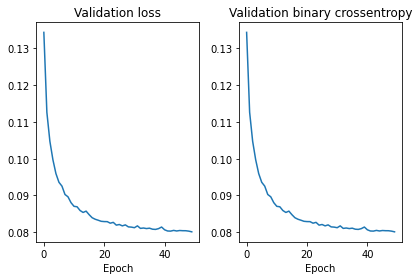

In [10]:
#Display loss curves
fig, axes = plt.subplots(1, 2)

val_loss_ax = axes[0]
val_loss_ax.plot(history.history['val_loss'])
val_loss_ax.title.set_text('Validation loss')
val_loss_ax.set_xlabel('Epoch')

val_bincross_ax = axes[1]
val_bincross_ax.plot(history.history['val_binary_crossentropy'])
val_bincross_ax.title.set_text('Validation binary crossentropy')
val_bincross_ax.set_xlabel('Epoch')

plt.tight_layout()
plt.show()

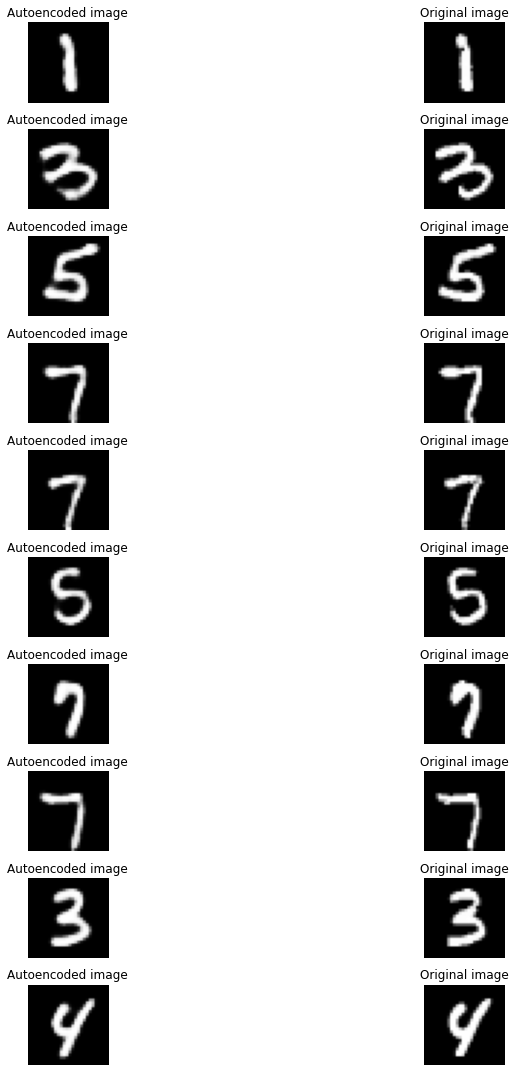

In [90]:
# Visualize X examples.
n = 10
visualization_start_index = np.random.randint(0, len(x_test))

fig, axes = plt.subplots(1 * n, 2)

for i in range(n):
    test_index = visualization_start_index + i
    x_encoded = encoder.predict(x_test[test_index].reshape(1, -1))
    x_predicted = decoder.predict(x_encoded)    

    #Autoencoder results
    ax_predicted = axes[i][0]
    ax_predicted.imshow(x_predicted.reshape((28, 28)),cmap='gray')
    ax_predicted.axis('off')
    ax_predicted.title.set_text('Autoencoded image')
    
    #Actual image.
    ax_original = axes[i][1]
    ax_original.imshow(x_test[test_index].reshape((28, 28)),cmap='gray')
    ax_original.axis('off')
    ax_original.title.set_text('Original image')

fig.set_size_inches(15, 15)
plt.tight_layout()
plt.show()

In [17]:
ae_test = full_model.predict(x_test)

In [36]:
ae_train = full_model.predict(x_train)

In [37]:
ae_train = pd.DataFrame(ae_train)
ae_test = pd.DataFrame(ae_test)

ae_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2.811033e-08,6.015660e-09,2.636376e-09,3.087165e-10,1.239715e-09,2.952814e-10,6.492692e-09,1.103462e-09,3.576030e-09,2.383345e-09,2.253946e-09,2.850918e-09,9.111048e-08,1.048933e-11,2.650717e-12,3.218559e-08,9.389430e-10,1.892027e-09,4.186012e-09,1.089293e-09,6.680176e-09,7.680379e-09,3.080884e-09,2.332846e-09,1.951283e-08,3.628625e-09,1.146192e-09,3.562623e-10,1.234983e-09,4.914165e-10,1.089613e-09,5.256227e-09,3.649518e-09,3.363589e-08,1.282267e-09,1.044951e-08,6.191545e-12,1.485694e-11,2.953656e-12,3.825916e-13,...,1.466466e-21,7.522629e-19,4.168008e-20,2.706977e-19,1.322872e-21,7.821026e-16,3.032486e-15,3.670941e-10,5.816749e-09,6.074578e-13,4.728334e-09,4.604394e-09,1.444147e-09,5.304773e-09,4.689945e-09,5.405354e-10,4.591380e-09,1.634909e-11,8.159016e-14,2.094219e-17,1.222956e-16,1.064365e-15,5.252546e-14,2.003722e-17,3.436291e-18,1.315076e-16,7.403427e-20,1.724469e-20,2.451520e-18,6.050468e-17,3.409273e-20,7.994455e-20,1.956368e-22,1.168581e-20,3.272972e-17,4.331360e-11,3.926937e-10,3.911114e-09,5.022200e-09,1.981459e-09
1,2.558848e-09,5.985628e-09,1.076705e-08,7.218871e-10,2.088802e-09,4.972253e-10,5.406285e-09,7.098760e-09,1.698139e-09,2.937026e-09,1.045399e-09,1.686489e-09,9.514845e-08,2.137422e-10,1.167753e-11,2.792298e-08,1.623689e-09,1.662323e-09,7.754060e-10,2.040524e-09,1.081991e-09,1.320272e-08,8.410073e-09,6.868069e-09,4.211576e-09,9.728609e-10,8.429001e-10,1.630753e-09,9.862418e-10,4.613775e-09,1.296334e-08,2.341980e-10,1.125357e-09,2.473310e-08,4.571474e-09,7.901748e-10,6.252520e-12,3.161172e-17,2.357585e-18,2.009037e-14,...,6.792098e-08,2.728612e-05,8.739598e-05,1.481670e-02,5.261600e-04,1.648895e-07,1.765391e-05,6.211216e-06,3.944155e-07,1.038264e-18,3.582864e-09,4.360900e-09,2.732674e-09,1.455998e-09,9.264460e-10,2.245288e-08,1.700278e-08,2.698603e-13,3.577624e-18,2.308050e-22,1.018244e-19,2.148402e-16,1.105613e-20,2.837654e-20,8.190389e-25,3.969221e-24,6.738705e-22,1.240607e-12,1.193629e-08,5.808511e-09,3.012053e-10,1.417967e-08,1.151171e-11,1.291639e-09,6.303056e-10,2.022245e-08,6.899462e-09,1.412174e-09,4.214002e-09,1.521342e-09
2,2.759756e-08,7.922382e-09,2.206350e-08,3.107639e-08,1.327033e-08,1.103288e-08,7.933360e-09,2.836476e-08,2.496206e-08,1.149525e-08,1.882256e-08,6.657957e-08,3.737316e-06,1.707649e-09,7.642075e-10,3.877848e-07,2.587443e-08,2.037612e-08,1.021424e-08,5.192794e-08,2.111016e-08,2.679457e-09,1.417774e-09,7.791289e-09,1.851534e-08,4.892358e-09,5.326473e-08,1.382955e-08,2.795223e-08,2.437761e-09,4.220069e-08,6.465529e-09,7.854135e-09,1.391367e-06,8.255658e-08,6.093398e-06,3.841516e-08,1.666205e-10,1.920583e-10,1.434402e-12,...,3.246684e-17,1.673881e-14,5.900313e-15,2.806620e-14,2.485409e-18,6.083216e-13,4.609684e-13,3.410345e-13,6.059952e-09,2.488509e-12,4.759260e-09,1.179383e-08,5.640822e-08,6.350290e-09,5.339918e-09,2.284556e-08,7.882635e-09,6.549252e-11,2.343946e-10,5.141635e-15,3.331886e-12,2.246184e-11,8.405478e-11,9.284311e-13,5.042910e-18,8.194043e-18,1.744574e-16,2.764875e-13,3.796280e-13,1.016634e-11,2.559062e-14,3.499421e-16,8.108808e-19,6.247132e-16,9.563281e-15,3.973092e-09,1.696352e-08,1.249143e-08,1.177016e-08,1.753803e-08
3,8.669774e-09,3.730765e-09,1.437574e-08,1.582987e-09,1.152425e-08,6.010912e-09,7.081184e-08,5.431028e-09,2.832199e-08,5.094588e-09,1.444081e-08,7.898935e-09,1.431886e-10,1.646283e-15,1.482296e-17,5.028648e-10,5.701545e-09,1.760348e-08,1.655038e-08,2.406675e-08,2.570335e-08,2.571041e-08,3.188307e-09,3.190024e-08,1.254185e-08,6.833651e-09,1.213714e-08,4.642216e-09,2.511311e-08,8.532952e-09,1.396364e-08,9.176676e-08,1.203304e-09,6.703253e-09,3.581130e-12,8.510257e-14,2.186469e-22,9.966311e-21,1.073585e-22,4.350093e-20,...,3.352855e-15,1.112708e-15,3.662835e-14,7.622970e-15,5.196315e

#Run Autoencoded Values Through Classification Model

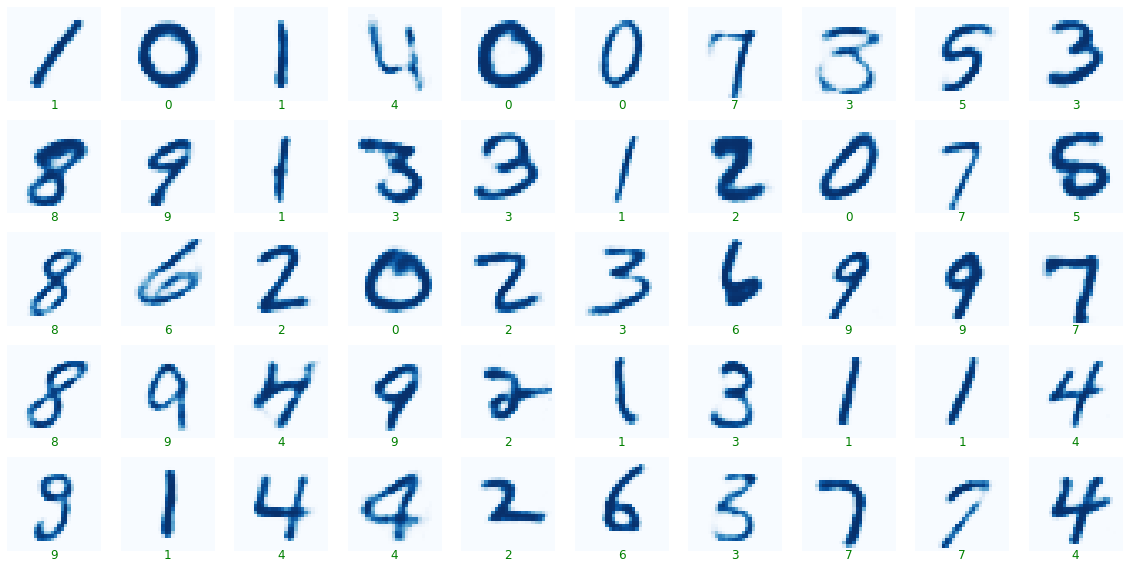

In [84]:
#Visualize the train autoencoded values and labels
rows = 5 
cols = 10 

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1)
    plt.imshow(ae_train.values[i].reshape([28,28]),cmap="Blues") 
    plt.axis("off")
    plt.title(str(y_train[i]), y=-0.15,color="green")

In [39]:
train = pd.read_csv('train.csv')

y_train = train['label']

ae_train.shape, y_train.shape, ae_test.shape

((42000, 784), (42000,), (28000, 784))

In [64]:
#Split train data to run through Random Classifier
from sklearn.model_selection import train_test_split
X_train_RC, X_test_RC, y_train_RC, y_test_RC = train_test_split(ae_train.values, y_train, test_size = 0.2, random_state= 42)

In [65]:
RANDOM_SEED = 1

In [66]:
%%time

import time

# create an empty list to store time results
rf_time = []

#fit a Random Forest Classifier onto the training set
from sklearn.ensemble import RandomForestClassifier

start_time = time.clock()
rf_clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=10, bootstrap=True, random_state=RANDOM_SEED)
rf_clf.fit(X_train_RC,y_train_RC)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_time.append(runtime)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 11.3 s, sys: 2.81 ms, total: 11.3 s
Wall time: 11.4 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


In [75]:
y_pred_RC = rf_clf.predict(X_test_RC)

In [76]:
from sklearn.metrics import classification_report

print("Random Forest Classification Report: \n{}".format(classification_report(y_test_RC, y_pred_RC)))

Random Forest Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       816
           1       0.98      0.99      0.98       909
           2       0.93      0.95      0.94       846
           3       0.93      0.92      0.93       937
           4       0.94      0.94      0.94       839
           5       0.93      0.91      0.92       702
           6       0.95      0.95      0.95       785
           7       0.96      0.94      0.95       893
           8       0.93      0.93      0.93       835
           9       0.93      0.92      0.92       838

    accuracy                           0.94      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.94      0.94      0.94      8400



In [72]:
y_ae_test = rf_clf.predict(ae_test)

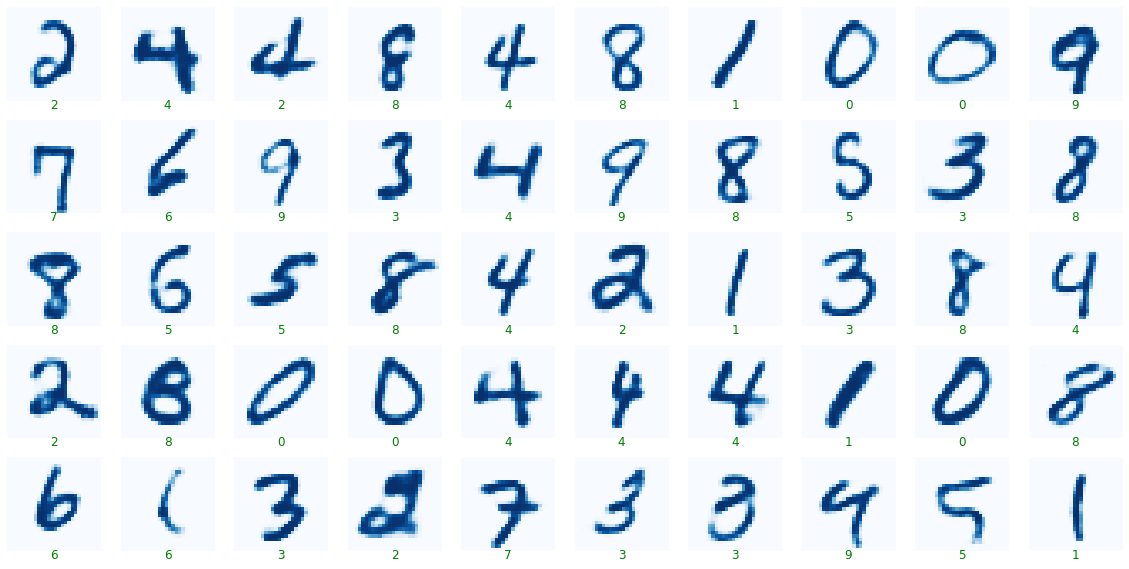

In [85]:
#Visualize the test autoencoded values and predicted labels
rows = 5 
cols = 10 

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1)
    plt.imshow(ae_test.values[i].reshape([28,28]),cmap="Blues") 
    plt.axis("off")
    plt.title(str(y_ae_test[i]), y=-0.15,color="green")

In [79]:
test["label"] = y_ae_test

test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
ImageId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Produce Results for Kaggle

In [27]:
cols = test.columns.tolist()

cols = cols[-1:]+cols[:-1]
test = test[cols]

test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
test1_kaggle = test[["label"]]

In [51]:
test1_kaggle.describe()

,label
count,28000.000000
mean,4.402071
std,2.890068
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


In [83]:
test1_kaggle.index.names = ['ImageId']
test1_kaggle.index = test1_kaggle.index +1

test1_kaggle.head(5)

,label
ImageId,
2,2
3,4
4,2
5,8
6,4


In [82]:
test1_kaggle.to_csv('Callaghan_AutoEncoder_RClassifier.csv')

#Kaggle Results
User: ccallag11

Score: 0.103